In [561]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from math import comb

In [562]:
num_anchors = 100 #Number of anchors around the circle
line_darkness = 0.4 #Brightness of the center of each line

In [563]:
def preprocess_image(image_path: str):
    """Returns a 2D numpy array with a greyscale, square image
    Args:
        image_path: Path to the image file
    Returns:
        img: The numpy 2D array of the image
        new_center: The center of the image
        radius: The radius of the image
    """
    # Load the image in grayscale
    img = Image.open(image_path).convert("L")

    # Normalize the image to [0, 1] and invert so that 1 is dark and 0 is bright
    img = 1 - np.array(img) / 255.0

    # Transpose the image to switch to (x, y) format
    img = img.T

    # Determine the center and radius
    width, height = img.shape
    center = (int(width / 2), int(height / 2))
    radius = min(center[0], center[1])  # Subtract 5 from the radius

    # Create the circular mask
    x, y = np.ogrid[-center[0]:width-center[0], -center[1]:height-center[1]]
    mask = x*x + y*y <= radius*radius

    # Apply the mask
    img = np.multiply(img, mask)

    # Crop the image
    img = img[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius]

    # The center is now at the middle of the cropped image
    new_center = (radius, radius)

    return img, new_center, radius

In [564]:
def create_anchors(center, radius, num_anchors):
    """Creates a list of tuples, each being the cordinates of an anchor
    Args:
        center: The center of the image
        radius: The radius of the image (1/2 of the width)
        num_anchors: The number of the anchors around the image
    """
    # Calculate the coordinates of the anchor points
    angles = np.linspace(0, 2*np.pi, num_anchors, endpoint=False)
    anchor_x = np.round(center[0] + (radius - 1) * np.cos(angles)).astype(int)
    anchor_y = np.round(center[1] + (radius - 1) * np.sin(angles)).astype(int)
    anchors = list(zip(anchor_x, anchor_y))
    
    return anchors

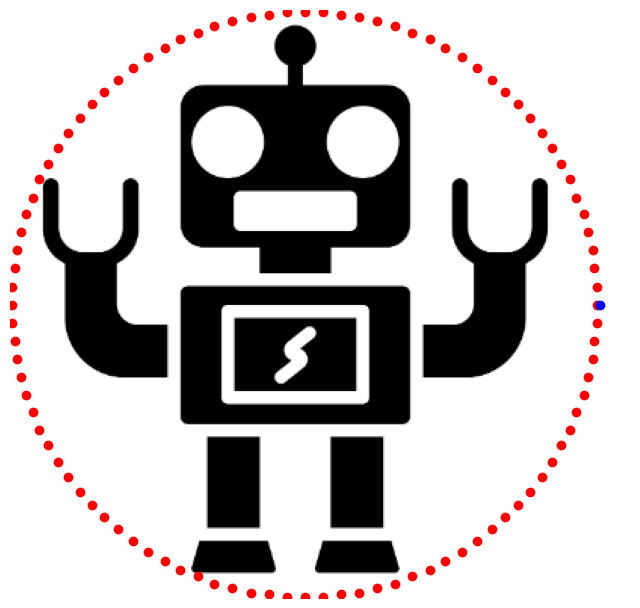

In [565]:
# Preprocess image
img, center, radius = preprocess_image("../data/robot.png")

# Create anchors
anchors = create_anchors(center, radius, num_anchors)

plt.figure(figsize=(8, 8))  
plt.imshow(img.T, cmap='gray_r')
anchors_x, anchors_y = zip(*anchors)
plt.scatter(anchors_x, anchors_y, color='red')
plt.scatter(391, 195, color='blue')
plt.axis('off')
plt.show()

In [566]:
def is_in_circle(coord, center, radius):
    """Check if a pixel is within the circle."""
    return (coord[0] - center[0]) ** 2 + (coord[1] - center[1]) ** 2 <= radius ** 2

In [567]:
print(anchors)

[(389, 195), (389, 207), (387, 219), (386, 231), (383, 243), (380, 255), (375, 266), (371, 278), (365, 288), (359, 299), (352, 309), (344, 319), (336, 328), (328, 336), (319, 344), (309, 352), (299, 359), (288, 365), (278, 371), (266, 375), (255, 380), (243, 383), (231, 386), (219, 387), (207, 389), (195, 389), (183, 389), (171, 387), (159, 386), (147, 383), (135, 380), (124, 375), (112, 371), (102, 365), (91, 359), (81, 352), (71, 344), (62, 336), (54, 328), (46, 319), (38, 309), (31, 299), (25, 288), (19, 278), (15, 266), (10, 255), (7, 243), (4, 231), (3, 219), (1, 207), (1, 195), (1, 183), (3, 171), (4, 159), (7, 147), (10, 135), (15, 124), (19, 112), (25, 102), (31, 91), (38, 81), (46, 71), (54, 62), (62, 54), (71, 46), (81, 38), (91, 31), (102, 25), (112, 19), (124, 15), (135, 10), (147, 7), (159, 4), (171, 3), (183, 1), (195, 1), (207, 1), (219, 3), (231, 4), (243, 7), (255, 10), (266, 15), (278, 19), (288, 25), (299, 31), (309, 38), (319, 46), (328, 54), (336, 62), (344, 71), (

In [579]:
def create_circle_mask(center, radius, shape):
    """Create a boolean mask for a circle with a border."""
    x = np.arange(0, shape[1])[None, :]
    y = np.arange(0, shape[0])[:, None]
    mask = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2

    # Add a border of "False" values
    mask = np.pad(mask, pad_width=1, mode='constant', constant_values=False)

    return mask

In [569]:
if is_in_circle((391, 195), center, radius): print("test")

In [580]:
mask = create_circle_mask(center, radius, img.shape)

In [581]:
print(mask[0,195])

False


In [571]:
print(mask[391, 195])

IndexError: index 391 is out of bounds for axis 0 with size 390

In [ ]:
def draw_line(p0: tuple, p1: tuple, multiplier: float, mask):
    """Creates a dictionary of coordinates and their darkness values of a line between two points. Uses Xiaolin Wu’s anti-aliasing algorithm
    Args: 
        p0: The first coordinate for the line
        p1: The second cordinate for the line
        multiplier: The darkness value that gets multiplied by each pixel
        mask: The boolean mask for a circle
    Returns:
        A dictionary of each pixel in the line and their darkness value
    """
    x0, y0 = p0
    x1, y1 = p1
    img = {}
    steep = abs(y1 - y0) > abs(x1 - x0)
    if steep:
        x0, y0 = y0, x0
        x1, y1 = y1, x1

    if x0 > x1:
        x0, x1 = x1, x0
        y0, y1 = y1, y0

    dx = x1 - x0
    dy = y1 - y0
    gradient = dy / dx if dx != 0 else 1

    # handle first endpoint
    xend = round(x0)
    yend = y0 + gradient * (xend - x0)
    xgap = 1 - ((x0 + 0.5) % 1)
    xpxl1 = xend
    ypxl1 = int(yend)
    if steep:
        if mask[ypxl1, xpxl1]: img[(ypxl1, xpxl1)] = xgap * (1 - (yend % 1)) * multiplier
        if mask[ypxl1+1, xpxl1]: img[(ypxl1+1, xpxl1)] = xgap * (yend % 1) * multiplier
    else:
        if mask[xpxl1, ypxl1]: img[(xpxl1, ypxl1)] = xgap * (1 - (yend % 1)) * multiplier
        if mask[xpxl1, ypxl1+1]: img[(xpxl1, ypxl1+1)] = xgap * (yend % 1) * multiplier
    intery = yend + gradient

    # handle second endpoint
    xend = round(x1)
    yend = y1 + gradient * (xend - x1)
    xgap = (x1 + 0.5) % 1
    xpxl2 = xend
    ypxl2 = int(yend)
    if steep:
        if mask[ypxl2, xpxl2]: img[(ypxl2, xpxl2)] = xgap * (1 - (yend % 1)) * multiplier
        if mask[ypxl2+1, xpxl2]: img[(ypxl2+1, xpxl2)] = xgap * (yend % 1) * multiplier
    else:
        if mask[xpxl2, ypxl2]: img[(xpxl2, ypxl2)] = xgap * (1 - (yend % 1)) * multiplier
        if mask[xpxl2, ypxl2+1]: img[(xpxl2, ypxl2+1)] = xgap * (yend % 1) * multiplier

    # main loop
    for x in range(int(xpxl1 + 1), int(xpxl2)):
        if steep:
            if mask[int(intery), x]: img[(int(intery), x)] = (1 - (intery % 1)) * multiplier
            if mask[int(intery)+1, x]: img[(int(intery)+1, x)] = (intery % 1) * multiplier
        else:
            if mask[x, int(intery)]: img[(x, int(intery))] = (1 - (intery % 1)) * multiplier
            if mask[x, int(intery)+1]: img[(x, int(intery)+1)] = (intery % 1) * multiplier
        intery += gradient


    #Remove any pixels outside of circle
    """for pixel in img:
        if not is_in_circle(pixel, center, radius):
            print(pixel)"""
    
    return img

testdraw = draw_line(anchors[0], anchors[5], 1, mask)

In [ ]:
print(mask[391, 195])

False


In [ ]:
#testdraw = draw_line(anchors[0], anchors[5], 1)

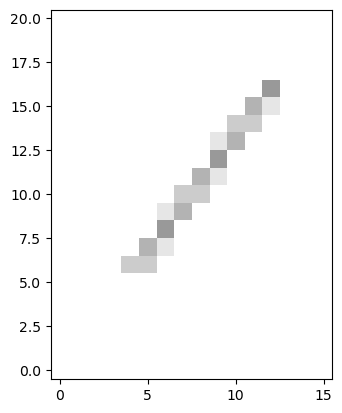

In [ ]:
def test_line(p1, p2):
    # Get the maximum coordinates to determine image size
    max_x = max(p1[0], p2[0])
    max_y = max(p1[1], p2[1])
    
    # Create an empty image
    temp_img = np.zeros((max_x + 1, max_y + 1))
    
    temp_mask = create_circle_mask((int(temp_img.shape[0]/2), int(temp_img.shape[1]/2)), min([int(temp_img.shape[0]/2), int(temp_img.shape[1]/2)]), img.shape)
    line_pixels = draw_line(p1, p2, 0.4, temp_mask)

    # Set the pixel values
    for pixel, value in line_pixels.items():
        temp_img[pixel] = value

    # Display the image
    plt.imshow(temp_img, cmap='gray_r', origin='lower', vmin=0, vmax=1)
    plt.show()

# Test the function
p1 = (0, 0)
p2 = (20, 15)
test_line(p1, p2)

In [584]:
def generate_all_lines(start_anchor):
    line_list = {}
    for end_anchor in anchors:
        if end_anchor is not start_anchor:
            both_anchors = tuple(sorted((start_anchor, end_anchor)))
            if both_anchors not in line_list:
                line = draw_line(both_anchors[0], both_anchors[1], line_darkness, mask)
                line_list[both_anchors] = line
    return line_list

In [585]:
#benchmark
start_time = time.perf_counter()
benchmark = generate_all_lines(anchors[0])
print(f"Starting Benchmark for ")
run_time = (time.perf_counter() - start_time)*1000
estimated_total_time = run_time*(comb(num_anchors, 2)/num_anchors)
print(f"Done! Generated {len(benchmark)} anchor lines on a canvas of size of {radius*2} in {round(run_time, 1)} milliseconds. Estimated time for generating line dict about {round(estimated_total_time/1000, 1)} seconds")

Starting Benchmark for 
Done! Generated 99 anchor lines on a canvas of size of 390 in 48.3 milliseconds. Estimated time for generating line dict about 2.4 seconds


In [591]:
def make_line_dict(anchors):
    line_dict = {}
    for start_anchor in tqdm(anchors, desc="Creating Lines"):
        for end_anchor in anchors:
            if start_anchor is not end_anchor:
                both_anchors = tuple(sorted((start_anchor, end_anchor)))
                if both_anchors not in line_dict:
                    line = draw_line(both_anchors[0], both_anchors[1], line_darkness, mask)
                    line_dict[both_anchors] = line
    return line_dict

In [590]:
line_dict = make_line_dict(anchors=anchors)

Creating Lines:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def difference(pixel1, pixel2):
    """Calculate the absolute difference between two pixel values."""
    return abs(pixel1 - pixel2)

In [ ]:
def create_difference_dict(image, center, radius):
    height, width = image.shape
    difference_dict = {}

    for y in range(height):
        for x in range(width):
            if mask[x, y]:
                # The canvas pixel value is 0 (white)
                difference_dict[(x, y)] = difference(0, image[y, x])
                
    return difference_dict

In [ ]:
def create_string_art_dict(image, center, radius):
    height, width = image.shape
    string_art_dict = {}

    for y in range(height):
        for x in range(width):
            if mask[x, y]:
                # The canvas pixel value is 0 (white)
                string_art_dict[(x, y)] = 0
                
    return string_art_dict

In [ ]:
difference_dict = create_difference_dict(img, center, radius)
string_art_dict = create_string_art_dict(img, center, radius)

In [ ]:
def get_initial_loss():
    loss = sum(difference_dict.values())
    return loss

In [ ]:
def find_new_loss(loss, string_line):
    for pixel, value in string_line.items():
        print(pixel)
        loss += difference(img[pixel[0], pixel[1]], value) - difference_dict[pixel]
    return loss
    

In [ ]:
def find_best_line(loss, start_anchor):
    best_loss = np.inf
    best_anchor = None
    for end_anchor in anchors:
        if start_anchor is not end_anchor:
            both_anchors = tuple(sorted((start_anchor, end_anchor)))
            temp_loss = find_new_loss(loss, line_dict[both_anchors])
            if(temp_loss < best_loss):
                best_loss = temp_loss
                best_anchor = end_anchor
    return best_loss, best_anchor

In [ ]:
loss = get_initial_loss()

In [ ]:
#print(line_dict[((14, 267), (384, 243))])

In [ ]:
#testloss = find_new_loss(loss, line_dict[((14, 267), (384, 243))])

In [ ]:
print(mask[2, 195])

True


In [ ]:
print(find_best_line(loss, anchors[0]))

(389, 195)
(390, 195)


IndexError: index 390 is out of bounds for axis 0 with size 390

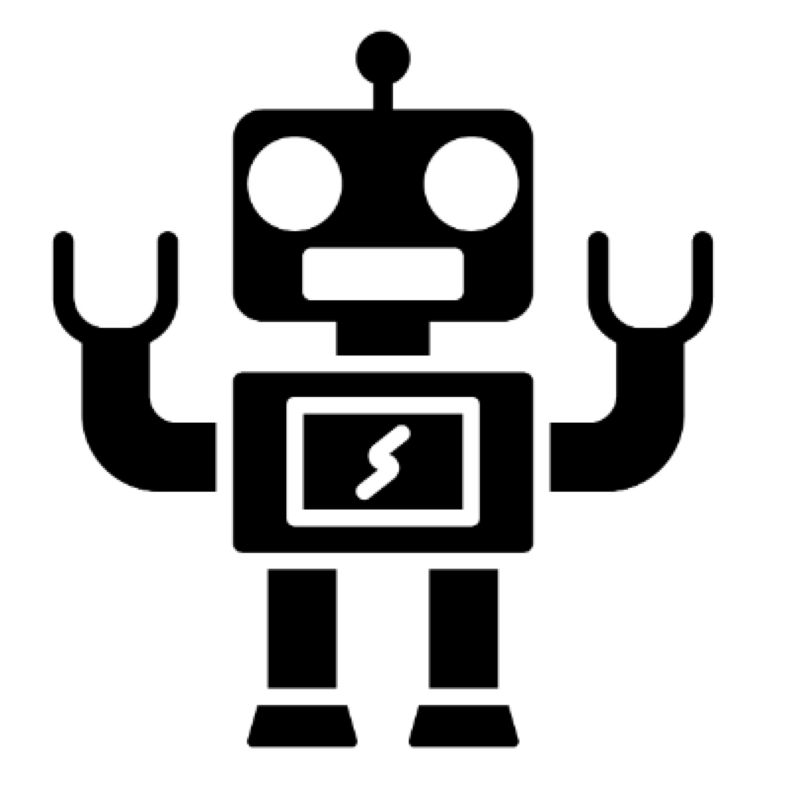

In [ ]:
# Create a blank white canvas
canvas = np.zeros((radius*2, radius*2))

# Draw the circle using the string_art_dict
for (x, y), value in difference_dict.items():
    canvas[y, x] = value  # subtract from 1 because 1 is white and 0 is black

# Show the canvas
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray_r', vmin=0, vmax=1)
plt.axis('off')
plt.show()